In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

import os

from ImagingSoftware.ImageProcessing import *
from ImagingSoftware.ImageClassifier import *

In [16]:
def exposure_dataset(path, n_loops, shape):
    n_files = len(os.listdir(path))
    skip = np.random.randint(0, n_files)
    training_crops = []
    training_labels = []
    for i, filename in enumerate(os.listdir(path)):
        data = loadmat(path + filename)
        if i == skip:
            processor = GreenImageProcessor(data['stack'], shape, n_loops)
            testing_crops, testing_labels = processor.make_dataset()
        else:
            processor = GreenImageProcessor(data['stack'], shape, n_loops)
            crops, labels = processor.make_dataset()
            training_crops.append(crops)
            training_labels.append(labels)
    training_crops = np.concatenate(tuple(training_crops), axis=0)
    training_labels = np.concatenate(tuple(training_labels), axis=0)
    return training_crops, training_labels, testing_crops, testing_labels

# Specifying File to Be Used for Analysis


In [19]:
exposure_times = [10, 20] # in ms
date = '06:23:23'

n_loops = 20
shape = np.array([10, 10])

training_crops = []
training_labels = []
testing_crops = []
testing_labels = []

for time in exposure_times:
    path = f"Data/{date}/imaging exposure time = {time}ms/"
    dataset = exposure_dataset(path, n_loops, shape)
    training_crops.append(dataset[0])
    training_labels.append(dataset[1])
    testing_crops.append(dataset[2])
    testing_labels.append(dataset[3])
training_crops = np.concatenate(tuple(training_crops), axis=0)
training_labels = np.concatenate(tuple(training_labels), axis=0)
testing_crops = np.concatenate(tuple(testing_crops), axis=0)
testing_labels = np.concatenate(tuple(testing_labels), axis=0)

(832000, 2) (832000, 18, 18)


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(832000, 2) (832000, 18, 18)


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(832000, 2) (832000, 18, 18)


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(832000, 2) (832000, 18, 18)


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(832000, 2) (832000, 18, 18)


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(832000, 2) (832000, 18, 18)


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


(832000, 2) (832000, 18, 18)
(454000, 2) (454000, 18, 18)
(454000, 2) (454000, 18, 18)
(454000, 2) (454000, 18, 18)
(454000, 2) (454000, 18, 18)
(454000, 2) (454000, 18, 18)


/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1200.

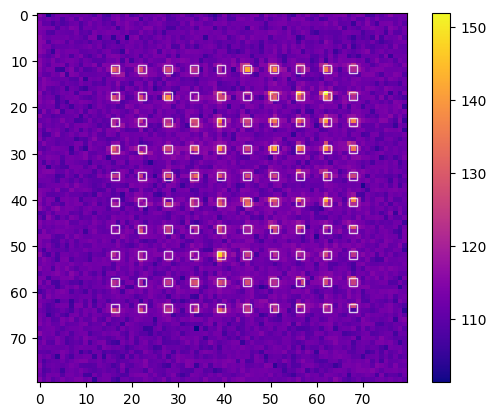

In [ ]:
processor = GreenImageProcessor(stacks[3], shape, n_loops)
processor.plot()

/opt/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


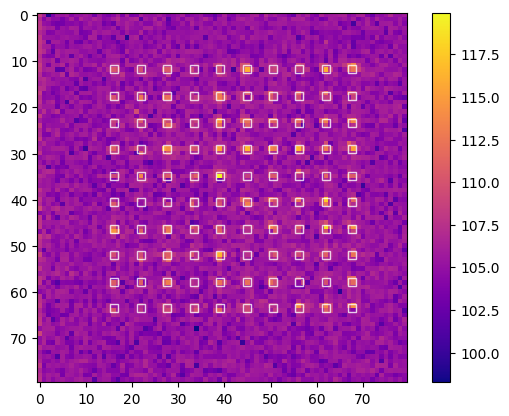

In [ ]:
processor = GreenImageProcessor(stacks[3], shape, n_loops)
processor.plot()